In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


안전모 데이터셋: https://public.roboflow.com/object-detection/hard-hat-workers


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14927, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 14927 (delta 7), reused 6 (delta 0), pack-reused 14908
Receiving objects: 100% (14927/14927), 14.00 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (10254/10254), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00


In [ ]:
import torch
from IPython.display import Image, clear_output

In [ ]:
%mkdir /content/yolov5/hhw
%cd /content/yolov5/hhw

/content/yolov5/hhw


In [ ]:
!curl -L 'https://public.roboflow.com/ds/MmbQWsagEI?key=b1RQo2EpQJ'> roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# yolov5s.pt 적용하여 추가 학습없이 detecting
%cd /content/yolov5
!python detect.py --weights yolov5s.pt --img 416 --conf 0.25 --source hhw/test/images/

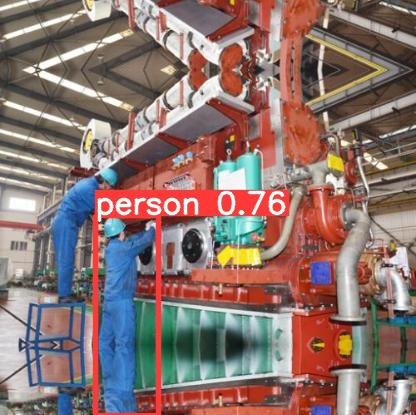

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

In [ ]:
from glob import glob

train_img_list = glob('/content/yolov5/hhw/train/images/*.jpg')
test_img_list = glob('/content/yolov5/hhw/test/images/*.jpg')

print(len(train_img_list), len(test_img_list))

5269 1766


In [ ]:
from sklearn.model_selection import train_test_split

test_img_list, val_img_list = train_test_split(test_img_list, test_size=0.5)
print(len(test_img_list), len(val_img_list))

883 883


In [ ]:
with open('/content/yolov5/hhw/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list)+'\n')
with open('/content/yolov5/hhw/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list)+'\n')
with open('/content/yolov5/hhw/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list)+'\n')

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
import yaml
%cat /content/yolov5/hhw/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['head', 'helmet', 'person']

In [ ]:
%%writetemplate /content/yolov5/hhw/data.yaml
train: ./hhw/train.txt
test: ./hhw/test.txt
val: ./hhw/val.txt

nc: 3
names: ['head', 'helmet', 'person']

In [ ]:
%cat /content/yolov5/hhw/data.yaml

train: ./hhw/train.txt
test: ./hhw/test.txt
val: ./hhw/val.txt

nc: 3
names: ['head', 'helmet', 'person']


In [ ]:
with open('/content/yolov5/hhw/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])
print(num_classes)

3


In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

학습(Training)
- img : 입력 이미지 크기 정의
- batch : 배치 크기 결정
- epochs : 학습 기간 개수 정의
- data : yaml 파일 경로
- cfg : 모델 구성 지정
- weights : 가중치에 대한 경로 지정
- name : 결과 이름
- nosave : 최종 체크포인트만 저장
- cache : 빠른 학습을 위한 이미지 캐시

In [ ]:
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 64 --epochs 50 --data ./hhw/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name hhw_results --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./hhw/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=hhw_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_ga

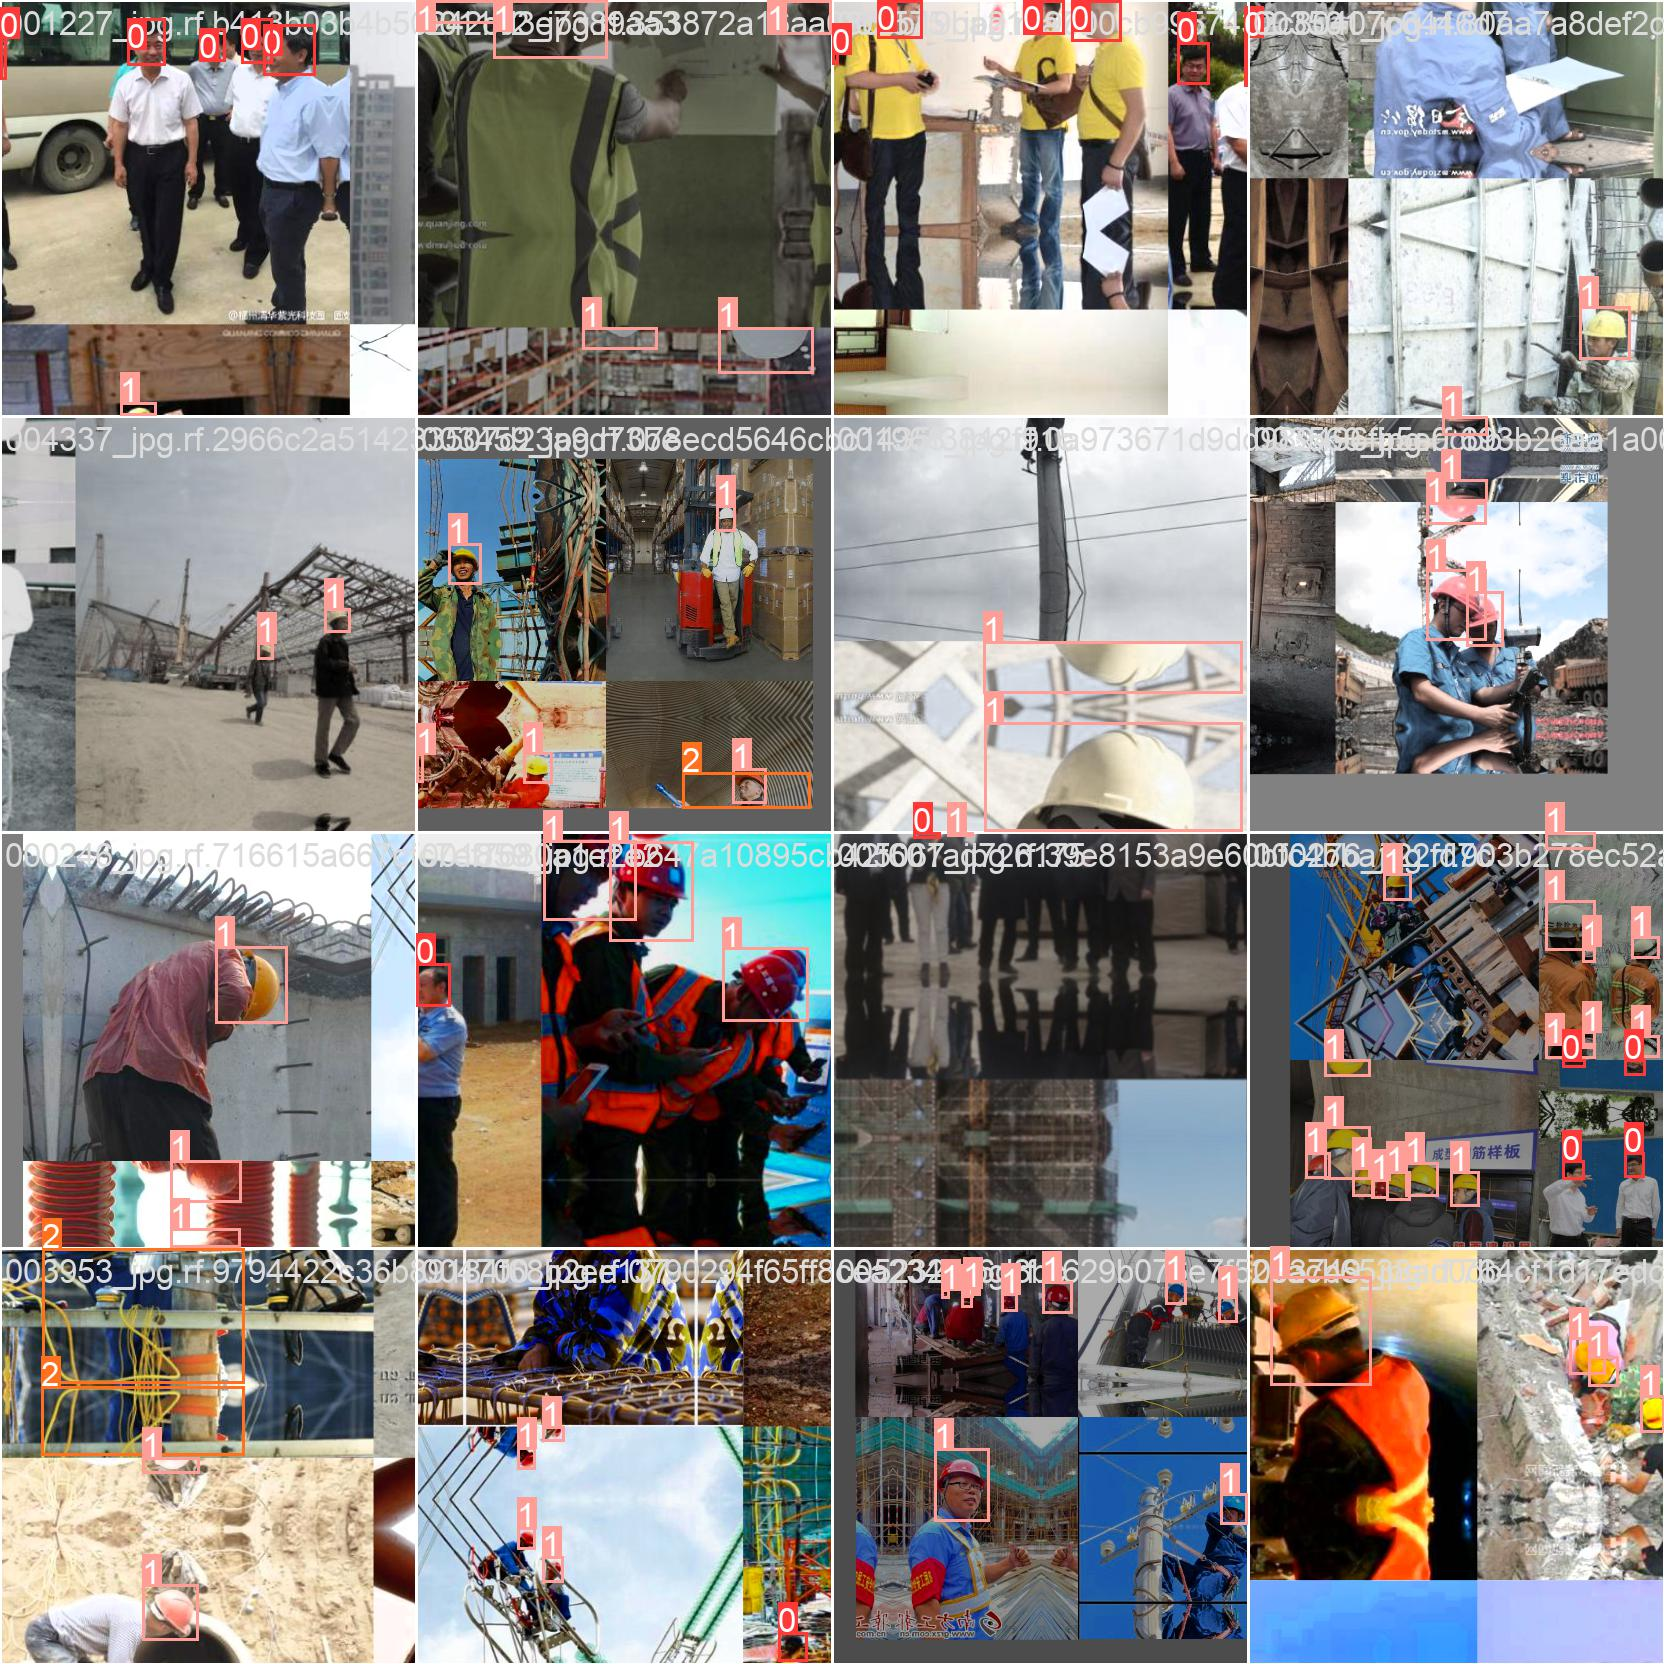

In [ ]:
from IPython.display import Image, display
Image(filename = '/content/yolov5/runs/train/hhw_results2/train_batch0.jpg', width = 1000)

In [ ]:
from IPython.display import Image, display
Image(filename = '/content/yolov5/runs/train/hhw_results2/train_batch0_labels.jpg', width = 1000)

FileNotFoundError: ignored

In [ ]:
#검증
!python val.py --data ./hhw/data.yaml --img 416 --iou 0.65 --weights runs/train/hhw_results2/weights/best.pt 

In [ ]:
#모델 내보내기
%cp /content/yolov5/runs/train/hhw_results2/weights/best.pt /content/drive/MyDrive/best_ex1.pt

In [ ]:
# best_ex1.pt 적용하여 추가 학습없이 detecting
!python detect.py --weights /content/drive/MyDrive/best_ex1.pt --img 640 --conf 0.4 --source ./hhw/test/images

In [ ]:
image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'))
display(Image(filename=image_name))